In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [2]:
import trimesh
import numpy as np


def create_plane(points):
    mesh = trimesh.Trimesh(vertices=points, faces=np.array([[0, 1, 3], [1, 2, 3]]))
    return mesh


def create_height_field(height_field, voxel_size=0.1, center_point=np.array([0, 0, 0])):
    meshes = []
    for x in range(height_field.shape[0] - 1):
        for y in range(height_field.shape[1] - 1):
            ls = []
            for x_ in range(x, x + 2):
                for y_ in range(y, y + 2):
                    ls.append([x_ * voxel_size + center_point[0], y_ * voxel_size + center_point[1], height_field[x_, y_]])
                    
            st = ls[1]
            ls[1] = ls[0]
            ls[0] = st
            
            if np.isnan( np.array([ls])).any():
                continue
                
            meshes.append(create_plane(np.array([ls])[0]))

    return trimesh.util.concatenate([meshes])

In [74]:
import warp
import numpy as np
import msgpack

ground_dir = "./Example_Files/GroundMap.msgpack"

with open(ground_dir, "rb") as data_file:
    data = data_file.read()
    ground_dict = msgpack.unpackb(data)

ground_dict["yRealRange"], ground_dict["xRealRange"]


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


([408.41799114345105, 465.2821527034588],
 [28.687711049338805, 167.14659462671332])

In [4]:
# Step 1 convert to mesh
height_field = np.array( ground_dict["GPMap"] )
center_point = np.array( [ground_dict["xRealRange"][0],ground_dict["yRealRange"][0],0])
mesh = create_height_field( height_field, ground_dict["res"], center_point)

mesh.show()

/home/anqiao/.local/lib/python3.8/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [56]:
import warp as wp
from warp.torch import to_torch as wp_to_torch
wp.init()

@wp.kernel
def raycast_generic(
    mesh: wp.uint64,
    ray_origin: wp.array(dtype=wp.vec3),
    ray_dir: wp.array(dtype=wp.vec3),
    height: wp.array(dtype=wp.float32),
):

    tid = wp.tid()

    t = float(0.0)  # hit distance along ray
    u = float(0.0)  # hit face barycentric u
    v = float(0.0)  # hit face barycentric v
    sign = float(0.0)  # hit face sign
    n = wp.vec3()  # hit face normal
    f = int(0)  # hit face index

    # ray cast against the mesh wp.vec3(0.0, 0.0, -1.0)
    if wp.mesh_query_ray(mesh, ray_origin[tid], ray_dir[tid], 1.0e6, t, u, v, sign, n, f):
        height[tid] = t


@wp.kernel
def raycast_normal(
    mesh: wp.uint64,
    ray_origin: wp.array(dtype=wp.vec3),
    height: wp.array(dtype=wp.float32),
):

    tid = wp.tid()

    t = float(0.0)  # hit distance along ray
    u = float(0.0)  # hit face barycentric u
    v = float(0.0)  # hit face barycentric v
    sign = float(0.0)  # hit face sign
    n = wp.vec3()  # hit face normal
    f = int(0)  # hit face index
    ray_dir = wp.vec3(0.0, 0.0, -1.0)
    # ray cast against the mesh wp.vec3(0.0, 0.0, -1.0)
    if wp.mesh_query_ray(mesh, ray_origin[tid], ray_dir, 1.0e6, t, u, v, sign, n, f):
        height[tid] = t

@wp.kernel
def raycast_for_variance(
    mesh: wp.uint64,
    ray_origin: wp.array(dtype=wp.vec3),
    ray_dir: wp.array(dtype=wp.vec3),
    height: wp.array(dtype=wp.float32),
    xdirection: wp.array(dtype=wp.float32),
    ydirection: wp.array(dtype=wp.float32),
):

    tid = wp.tid()

    t = float(0.0)  # hit distance along ray
    u = float(0.0)  # hit face barycentric u
    v = float(0.0)  # hit face barycentric v
    sign = float(0.0)  # hit face sign
    n = wp.vec3()  # hit face normal
    f = int(0)  # hit face index
    # ray cast against the mesh wp.vec3(0.0, 0.0, -1.0)
    if wp.mesh_query_ray(mesh, ray_origin[tid], ray_dir[tid], 1.0e6, t, u, v, sign, n, f):
        height[tid] = t
        position = ray_dir[tid]*t + ray_origin[tid]
        if(t!=0):
            xdirection[tid] = position[0]
            ydirection[tid] = position[1]

def get_distance( start_points, directions=None):
        """Raycasts environment mesh.
        If no direction is provide raycasts z down (0,0,-1) for all rays.

        Args:
            start_points (torch.Tensor): origin of the rays
            directions (torch.Tensor): optionally directions of rays
        Returns:
            [torch.Tensor]: ray lengts in meter
        """
        ray_origin = wp.types.array(
            ptr=start_points.data_ptr(),
            dtype=wp.vec3,
            length=start_points.shape[0],
            copy=False,
            owner=False,
            requires_grad=False,
            device=start_points.device.type,
        )
        ray_origin.tensor = start_points
        n = len(start_points)
        distances = wp.zeros(n, dtype=wp.float32, device=wp_device)

        if directions is not None:
            ray_dir = wp.types.array(
                ptr=directions.data_ptr(),
                dtype=wp.vec3,
                length=directions.shape[0],
                copy=False,
                owner=False,
                requires_grad=False,
                device=directions.device.type,
            )
            ray_dir.tensor = directions
            kernel = raycast_generic
            inputs = [wp_mesh.id, ray_origin, ray_dir, distances]
        else:
            kernel = raycast_normal
            inputs = [wp_mesh.id, ray_origin, distances]

        wp.launch(kernel=kernel, dim=n, inputs=inputs, device=wp_device)
        wp.synchronize()
        distances = wp_to_torch(distances)
        return distances
def get_positions( start_points, directions=None):
        """Raycasts environment mesh.
        If no direction is provide raycasts z down (0,0,-1) for all rays.

        Args:
            start_points (torch.Tensor): origin of the rays
            directions (torch.Tensor): optionally directions of rays
        Returns:
            [torch.Tensor]: ray lengts in meter
        """
        ray_origin = wp.types.array(
            ptr=start_points.data_ptr(),
            dtype=wp.vec3,
            length=start_points.shape[0],
            copy=False,
            owner=False,
            requires_grad=False,
            device=start_points.device.type,
        )
        ray_origin.tensor = start_points
        n = len(start_points)
        distances = wp.zeros(n, dtype=wp.float32, device=wp_device)
        ydirection = wp.zeros(n, dtype=wp.float32, device=wp_device)
        xdirection = wp.zeros(n, dtype=wp.float32, device=wp_device)

        ray_dir = wp.types.array(
            ptr=directions.data_ptr(),
            dtype=wp.vec3,
            length=directions.shape[0],
            copy=False,
            owner=False,
            requires_grad=False,
            device=directions.device.type,
        )
        ray_dir.tensor = directions
        kernel = raycast_for_variance
        inputs = [wp_mesh.id, ray_origin, ray_dir, distances, xdirection, ydirection]

        wp.launch(kernel=kernel, dim=n, inputs=inputs, device=wp_device)
        wp.synchronize()
        xdirection = wp_to_torch(xdirection)
        ydirection = wp_to_torch(ydirection)
        return xdirection, ydirection

In [6]:
# Raycasting a single image
m2 = mesh.as_open3d
                
vertices = np.array(m2.vertices).astype(np.float32)
triangles = np.array(m2.triangles).astype(np.uint32)

wp_device = "cuda" if str(device).find("cuda") != -1 else "cpu"
wp_mesh = wp.Mesh(
    points=wp.array(np.asarray(vertices), dtype=wp.vec3, device=wp_device),
    indices=wp.array(triangles.astype(np.int32), dtype=int, device=wp_device),
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:

pixel_cor = np.mgrid[vertices.min(axis=0)[0]:vertices.max(axis=0)[0]:0.1,
                     vertices.min(axis=0)[1]:vertices.max(axis=0)[1]:0.1]

vec = torch.from_numpy( pixel_cor ).to(device).T.reshape( (-1,2))
vec = torch.cat( [vec, torch.zeros_like(vec[:,0][:,None])] ,dim=1)
vec[:,2] = 10

vec = vec.type(torch.float32)
res = get_distance(vec)


Module __main__ load took 2.02 ms


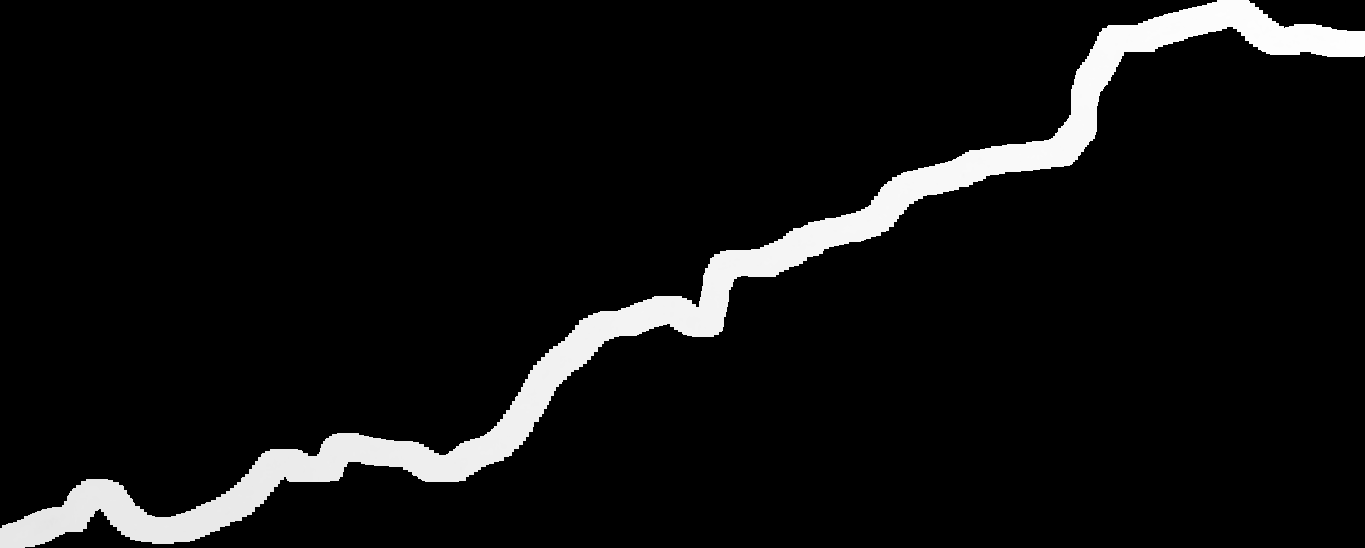

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
res /= res.max()
dis = res.reshape((pixel_cor.shape[2], pixel_cor.shape[1])).cpu().numpy()
Image.fromarray(np.uint8( dis*255))

Module __main__ load took 984.05 ms


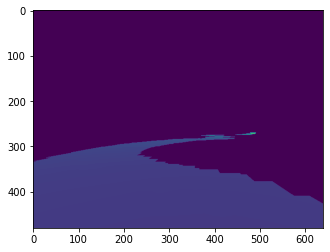

In [16]:
# NOT TESTED

fx,fy,cx,cy = 300,300,320,240
W,H = 640,480
pixel_cor = np.mgrid[0:W,0:H]
pixel_cor_hom = np.concatenate( [ pixel_cor, np.ones_like(pixel_cor[None,0,:,:])], axis=0 )
# https://i.stack.imgur.com/AGwu9.jpg  
K = np.array( [[fx, 0, cx],[0, fy, cy], [0,0,1]] )
K =np.array([349.5636550689, 0.0, 357.2746308879, 0.0, 349.4046775293, 264.3108985411, 0.0, 0.0, 1.0]).reshape(3, 3)
ray_dir = (np.linalg.inv(K) @ (pixel_cor_hom.reshape(3,-1))).T

ray_dir = ray_dir/ np.linalg.norm(ray_dir, axis=1)[:,None]

from scipy.spatial.transform import Rotation as R
H_map_cam = np.eye(4)

# H_map_cam[:3,3] =  np.array( [[410.51799114,  82.08771105,  -1.37993082]]) # position over one of the trianlge vertices
H_map_cam[:3,3] =  np.array( [[38.812, 458.915, -2.7]])

H_map_cam[:3,:3] = R.from_euler('xyz', [90, -90, 0], degrees=True).as_matrix() # looking down
# H_map_cam[:3,:3] = R.from_euler('xyz', [-90.7, 1.885, -121.030], degrees=True).as_matrix() # looking down


R = torch.from_numpy( H_map_cam ).to(device)[:3,:3]
directions = torch.from_numpy( ray_dir )
directions = directions.to(device).clone()
directions = (directions @ R).type(torch.float32)

start_points = torch.from_numpy( H_map_cam[:3,3] ).to(device)
start_points = start_points[None,:].repeat(ray_dir.shape[0],1).type(torch.float32)

dis = get_distance(start_points, directions)

%matplotlib inline

import matplotlib.pyplot as plt
dis = dis.reshape(W,H).cpu()
# To get nice colors
dis[dis==0] = dis[dis!=0].min()- (dis[dis!=0].max()-dis[dis!=0].min())/5
dis = dis/dis.max()*255
plt.imshow(dis.T)

Module __main__ load took 1041.64 ms


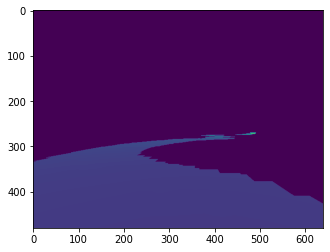

In [57]:
fx,fy,cx,cy = 300,300,320,240
W,H = 640,480
pixel_cor = np.mgrid[0:W,0:H]
pixel_cor_hom = np.concatenate( [ pixel_cor, np.ones_like(pixel_cor[None,0,:,:])], axis=0 )
# https://i.stack.imgur.com/AGwu9.jpg  
K = np.array( [[fx, 0, cx],[0, fy, cy], [0,0,1]] )
K =np.array([349.5636550689, 0.0, 357.2746308879, 0.0, 349.4046775293, 264.3108985411, 0.0, 0.0, 1.0]).reshape(3, 3)
ray_dir = (np.linalg.inv(K) @ (pixel_cor_hom.reshape(3,-1))).T

ray_dir = ray_dir/ np.linalg.norm(ray_dir, axis=1)[:,None]

from scipy.spatial.transform import Rotation as R
H_map_cam = np.eye(4)

# H_map_cam[:3,3] =  np.array( [[410.51799114,  82.08771105,  -1.37993082]]) # position over one of the trianlge vertices
H_map_cam[:3,3] =  np.array( [[38.812, 458.915, -2.7]])

H_map_cam[:3,:3] = R.from_euler('xyz', [90, -90, 0], degrees=True).as_matrix() # looking down
# H_map_cam[:3,:3] = R.from_euler('xyz', [-90.7, 1.885, -121.030], degrees=True).as_matrix() # looking down


R = torch.from_numpy( H_map_cam ).to(device)[:3,:3]
directions = torch.from_numpy( ray_dir )
directions = directions.to(device).clone()
directions = (directions @ R).type(torch.float32)

start_points = torch.from_numpy( H_map_cam[:3,3] ).to(device)
start_points = start_points[None,:].repeat(ray_dir.shape[0],1).type(torch.float32)

dis = get_distance(start_points, directions)
u, v = get_positions(start_points, directions)


%matplotlib inline

import matplotlib.pyplot as plt
dis = dis.reshape(W,H).cpu()
# To get nice colors
dis[dis==0] = dis[dis!=0].min()- (dis[dis!=0].max()-dis[dis!=0].min())/5
dis = dis/dis.max()*255
plt.imshow(dis.T)

In [21]:
uc = u.reshape(W, H).cpu()
vc = v.reshape(W, H).cpu()
confidence = np.array(ground_dict["Confidence"])[uc, vc]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [82]:
import numpy as np
uc = u.reshape(W, H).cpu().numpy()
vc = v.reshape(W, H).cpu().numpy()

uc[uc!=0] = np.floor(uc[uc!=0]/ground_dict["res"] - ground_dict["xNormal"])
uc = uc.astype(int)
vc[vc!=0] = np.floor(vc[vc!=0]/ground_dict["res"] - ground_dict["yNormal"])
vc = vc.astype(int)

confidence = np.array(ground_dict["Confidence"])
# confidence = 1 - (confidence - confidence.min())/(confidence.max() - confidence.min())
confidence = confidence[uc, vc]


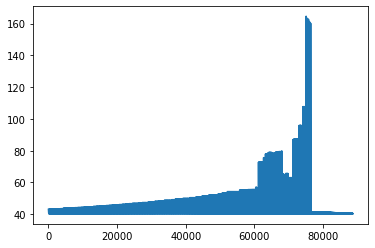

In [65]:
uc = u.cpu().numpy()
plt.plot(uc[uc!=0])
plt.show()

In [61]:
ground_dict["yRealRange"]

[408.41799114345105, 465.2821527034588]

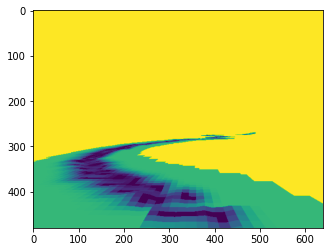

In [89]:
confidence[confidence==0]=confidence.max()+1/10*(confidence.max() - confidence.min())
plt.imshow(confidence.T)

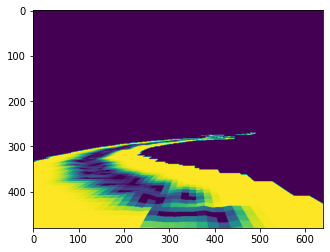

In [83]:
confidence[confidence==]=confidence.min()-1/2*(confidence.max() - confidence.min())
plt.imshow(confidence.T)

In [71]:
confidence

array([[1.        , 1.        , 1.        , ..., 0.03473503, 0.03473503,
        0.03473503],
       [1.        , 1.        , 1.        , ..., 0.03473503, 0.03473503,
        0.03473503],
       [1.        , 1.        , 1.        , ..., 0.03473503, 0.03473503,
        0.03473503],
       ...,
       [1.        , 1.        , 1.        , ..., 0.27103369, 0.27103369,
        0.27103369],
       [1.        , 1.        , 1.        , ..., 0.27103369, 0.27103369,
        0.27103369],
       [1.        , 1.        , 1.        , ..., 0.27103369, 0.27103369,
        0.27103369]])